### CA flood model for EA Input Test 1 Dataset

1. Load and plot DEM
2. Adds the boundary condition line on the left edge
3. Marks the output points
4. Plots the hydrograph (water level vs time)

In [19]:
from pathlib import Path

# --- Resolve repo structure ---
NOTEBOOK_DIR = Path.cwd()
REPO_ROOT = NOTEBOOK_DIR.parent          # 01_ea_benchmarks
DATA_DIR = REPO_ROOT / "data" / "test1" / "raw"
OUT_DIR = REPO_ROOT / "outputs"

# Create output directory if needed
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Input files ---
DEM_PATH = DATA_DIR / "test1DEM.asc"
BC_PATH  = DATA_DIR / "Test1BC.csv"
REF_PATH = DATA_DIR / "Test1output.csv"

# --- Sanity check ---
assert DATA_DIR.exists(), DATA_DIR
assert DEM_PATH.exists(), DEM_PATH
assert BC_PATH.exists(), BC_PATH
assert REF_PATH.exists(), REF_PATH

print("Paths OK")


Paths OK


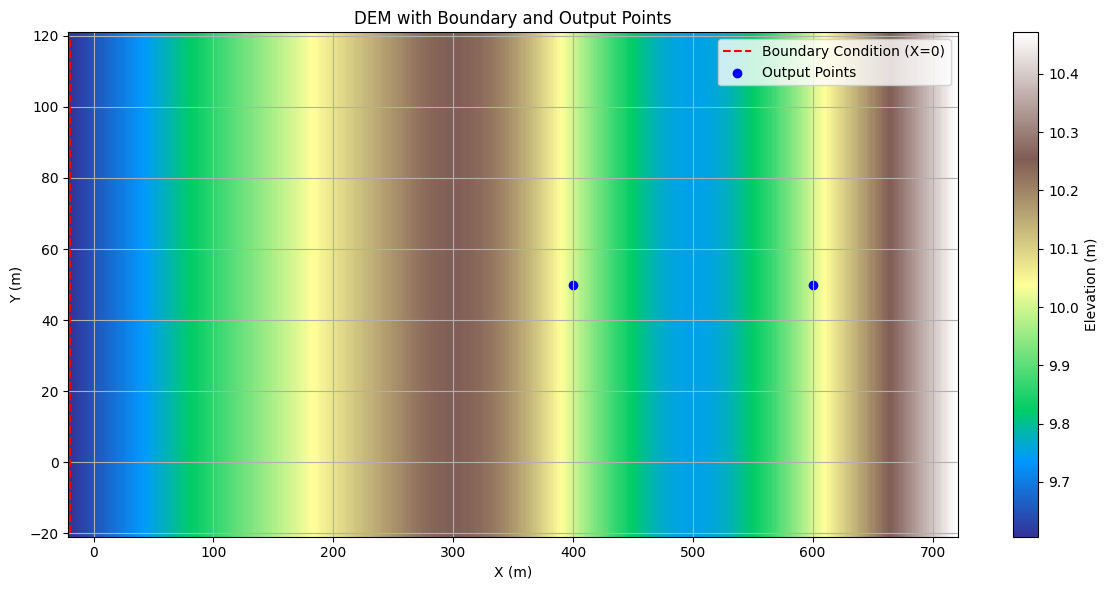

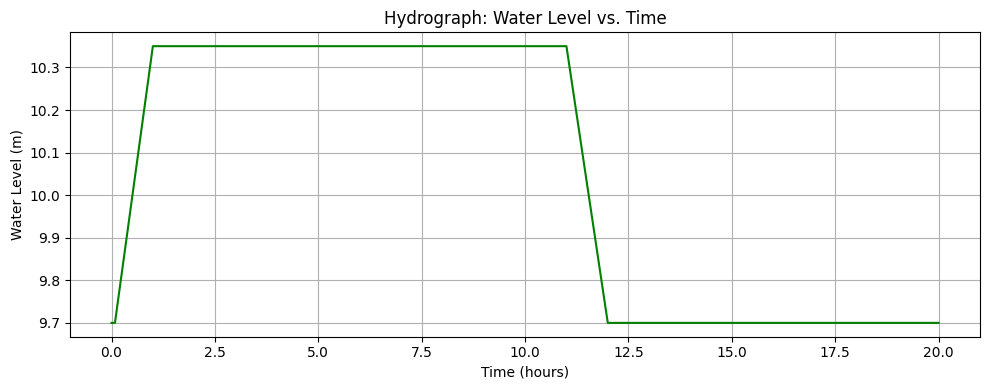

In [20]:
# ==============================================================
# Step 3: Import required libraries
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================
# Step 4: Load the DEM (.asc) file
# ==============================================================

def load_dem(filepath):
    with open(filepath, 'r') as file:
        # Read the 6-line ASCII grid header
        header = {line.split()[0].lower(): float(line.split()[1]) for line in [file.readline() for _ in range(6)]}
        data = np.loadtxt(file)
    return header, data

dem_header, dem_data = load_dem(DEM_PATH)

# ==============================================================
# Step 5: Setup grid from DEM header
# ==============================================================

ncols = int(dem_header['ncols'])
nrows = int(dem_header['nrows'])
xll = dem_header['xllcorner']
yll = dem_header['yllcorner']
cellsize = dem_header['cellsize']

x = np.linspace(xll, xll + cellsize * (ncols - 1), ncols)
y = np.linspace(yll, yll + cellsize * (nrows - 1), nrows)
X, Y = np.meshgrid(x, y[::-1])  # reverse Y for correct orientation

# ==============================================================
# Step 6: Load boundary condition and output point data
# ==============================================================

bc = pd.read_csv(BC_PATH)         # Must have 'Time (mins)' and 'Water level (m)'
outputs = pd.read_csv(REF_PATH) # Must have 'X' and 'Y'

# ==============================================================
# Step 7: Plot DEM with boundary and output points
# ==============================================================

plt.figure(figsize=(12, 6))
plt.pcolormesh(X, Y, dem_data, shading='auto', cmap='terrain')
plt.colorbar(label='Elevation (m)')

# Add boundary line (X = left edge)
plt.plot(np.zeros_like(y) + xll, y, 'r--', label='Boundary Condition (X=0)')

# Output points
plt.scatter(outputs['X'], outputs['Y'], color='blue', label='Output Points')

plt.title("DEM with Boundary and Output Points")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================================================
# Step 8: Plot the hydrograph
# ==============================================================

plt.figure(figsize=(10, 4))
plt.plot(bc['Time (mins)']/60, bc['Water level (m)'], color='green')
plt.title("Hydrograph: Water Level vs. Time")
plt.xlabel("Time (hours)")
plt.ylabel("Water Level (m)")
plt.grid(True)
plt.tight_layout()
plt.show()

- Load DEM
- Downsamples it to a 10m grid by block-averaging
- Builds three arrays:

1. Terrain grid 10 m -> X, Y, elevation
2. Output points
3. Boundary points -> left edge (Dirichlet BC line)

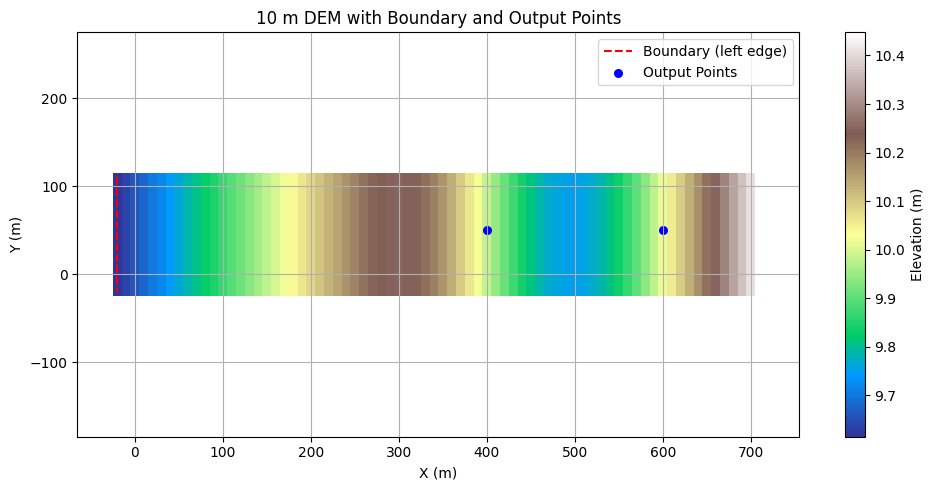

Prepared arrays saved in /Users/srijankumarjha/Desktop/01_ea_benchmarks/outputs
Hydrograph: 6 points | Duration = 20.00 h | WL = [9.70, 10.35] m


Simulating flood:   3%|▎         | 1970.0990153536616/72000 [00:01<00:53, 1308.49it/s]

📸 Snapshot captured at t = 0.50 h


Simulating flood:   5%|▌         | 3740.222938870529/72000 [00:03<01:23, 814.69it/s]  

📸 Snapshot captured at t = 1.00 h


Simulating flood:  10%|█         | 7275.356035571339/72000 [00:08<01:27, 737.49it/s] 

📸 Snapshot captured at t = 2.00 h


Simulating flood:  20%|██        | 14536.031867675834/72000 [00:18<01:18, 734.42it/s]

📸 Snapshot captured at t = 4.00 h


Simulating flood:  40%|████      | 28882.594767287817/72000 [00:39<01:01, 703.48it/s]

📸 Snapshot captured at t = 8.00 h


Simulating flood:  60%|██████    | 43331.34605335178/72000 [00:59<00:32, 873.35it/s] 

📸 Snapshot captured at t = 12.00 h


Simulating flood:  80%|████████  | 57754.92505729907/72000 [01:16<00:16, 863.48it/s] 

📸 Snapshot captured at t = 16.00 h


Simulating flood: 100%|█████████▉| 71962.66327979279/72000 [01:31<00:00, 992.49it/s] /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Simulating flood: 100%|██████████| 72000.3400871667/72000 [01:31<00:00, 785.07it/s] 


📸 Snapshot captured at t = 20.00 h
✅ Simulation complete


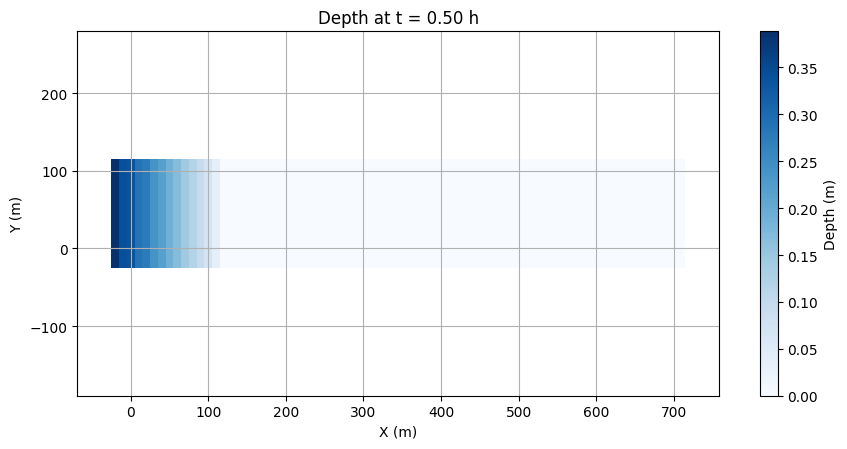

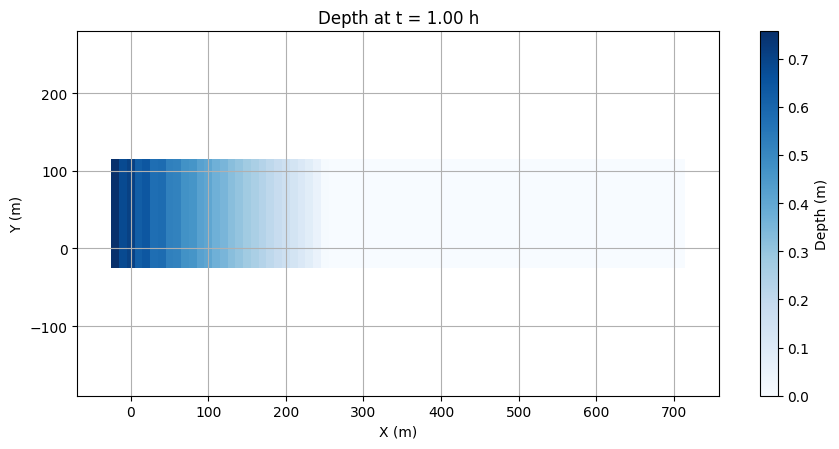

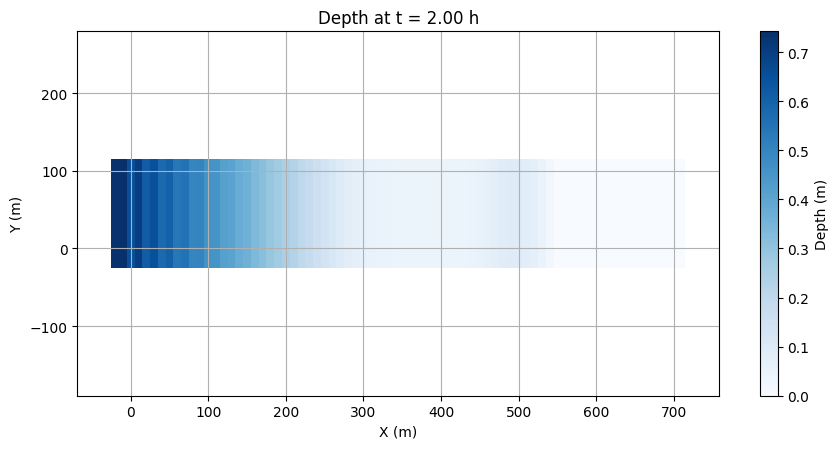

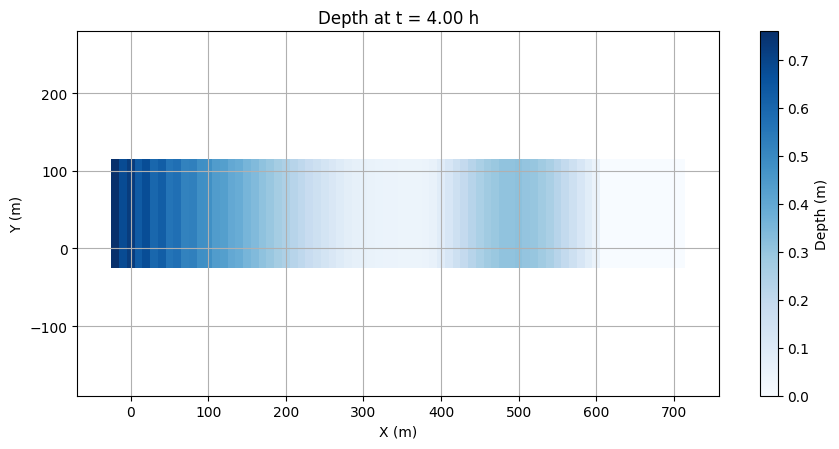

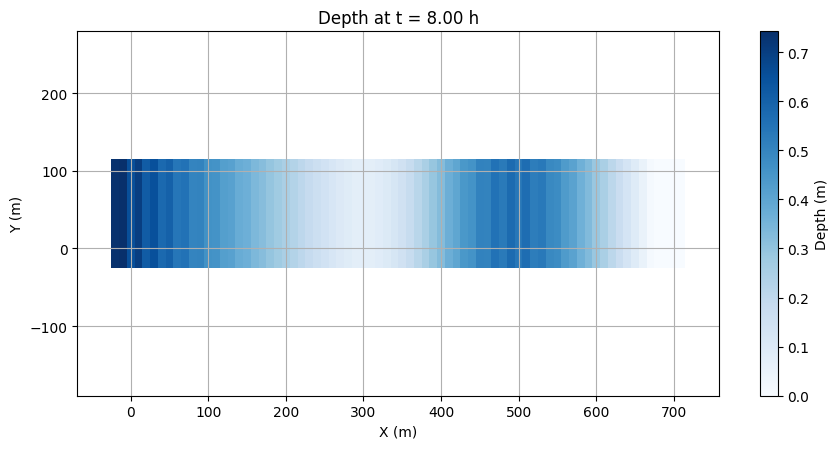

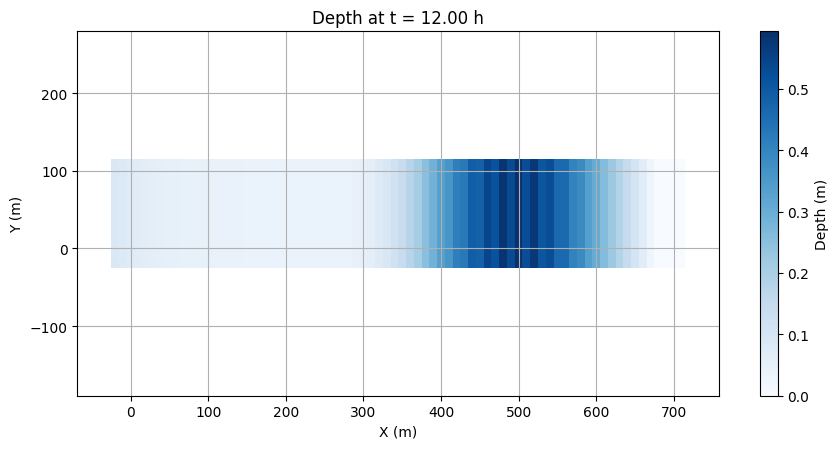

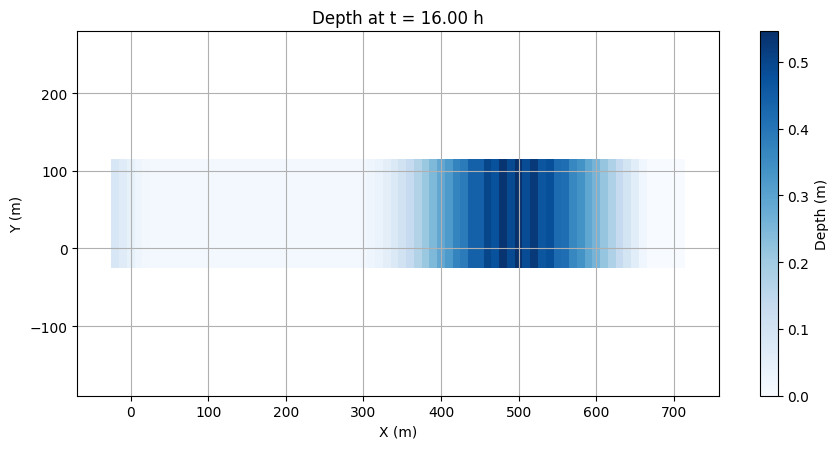

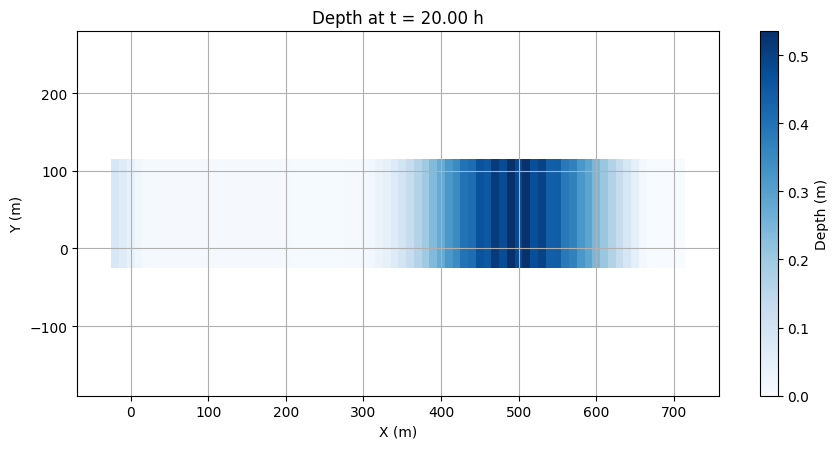

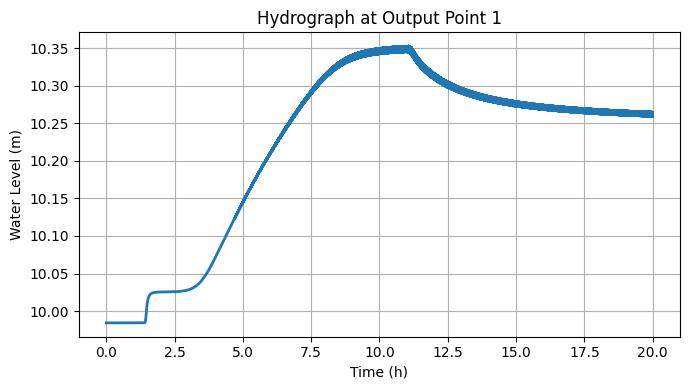

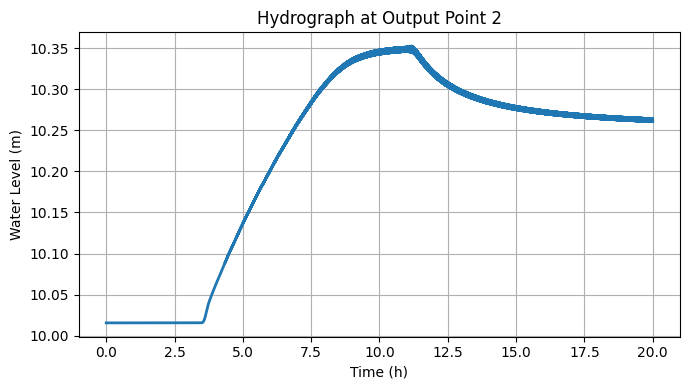

In [21]:
# --- Imports ---
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from tqdm import tqdm  # progress bar

plt.rcParams["figure.figsize"] = (8.5, 5)
plt.rcParams["axes.grid"] = True

TARGET_DX = 10.0  # target DEM resolution in meters
# ============================================================
# Utility Functions
# ============================================================

def load_dem_asc(filepath):
    """Load ESRI ASCII DEM -> header + elevation matrix."""
    with open(filepath, "r") as f:
        hdr = {}
        for _ in range(6):
            k, v = f.readline().split()
            hdr[k.lower()] = float(v)
        data = np.loadtxt(f)
    data[data == hdr.get("nodata_value", -9999)] = np.nan
    return hdr, data

def downsample_mean_nan(data, factor):
    """NaN-safe block averaging."""
    nrows_new = data.shape[0] // factor
    ncols_new = data.shape[1] // factor
    trimmed = data[:nrows_new*factor, :ncols_new*factor]
    blocks = trimmed.reshape(nrows_new, factor, ncols_new, factor)
    return np.nanmean(blocks, axis=(1, 3))

def make_grid_coords(xll, yll, dx, nx, ny):
    """Return meshgrid (X,Y)."""
    x = np.linspace(xll, xll + dx*(nx-1), nx)
    y = np.linspace(yll, yll + dx*(ny-1), ny)
    return np.meshgrid(x, y[::-1])

# ============================================================
# Preprocessing (DEM + outputs + boundary)
# ============================================================

def preprocess_to_arrays():
    hdr, Z_src = load_dem_asc(DEM_PATH)
    cs = hdr["cellsize"]
    factor = int(round(TARGET_DX / cs))
    Z10 = downsample_mean_nan(Z_src, factor)
    ny, nx = Z10.shape
    X10, Y10 = make_grid_coords(hdr["xllcorner"], hdr["yllcorner"], TARGET_DX, nx, ny)

    terrain_grid = np.dstack((X10, Y10, Z10))

    # Output points mapping
    outputs_df = pd.read_csv(REF_PATH)
    grid_xy = np.column_stack((X10.ravel(), Y10.ravel()))
    tree = cKDTree(grid_xy)
    _, idx = tree.query(outputs_df[["X", "Y"]].to_numpy(float))
    out_elev = Z10.ravel()[idx]
    output_points = np.column_stack((outputs_df[["X", "Y"]].to_numpy(float), out_elev))

    # Left boundary
    boundary_points = np.column_stack((X10[:, 0], Y10[:, 0], Z10[:, 0]))

    # Save
    np.save(OUT_DIR / "terrain_grid_10m.npy", terrain_grid)
    np.save(OUT_DIR / "output_points.npy", output_points)
    np.save(OUT_DIR / "boundary_points.npy", boundary_points)

    # Plot quick DEM preview
    plt.figure(figsize=(10, 5))
    pc = plt.pcolormesh(X10, Y10, np.ma.masked_invalid(Z10), shading='auto', cmap='terrain')
    plt.colorbar(pc, label="Elevation (m)")
    plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'r--', label='Boundary (left edge)')
    plt.scatter(output_points[:, 0], output_points[:, 1], c='b', s=30, label='Output Points')
    plt.title("10 m DEM with Boundary and Output Points")
    plt.xlabel("X (m)"); plt.ylabel("Y (m)"); plt.legend(); plt.axis('equal')
    plt.tight_layout(); plt.show()

    print(f"Prepared arrays saved in {OUT_DIR}")
    return terrain_grid, output_points, boundary_points

terrain, outputs, boundary = preprocess_to_arrays()
X, Y, Z = terrain[:, :, 0], terrain[:, :, 1], terrain[:, :, 2]
ny, nx = Z.shape
dx = float(np.median(np.diff(np.unique(X[0, :]))))

# ============================================================
# Hydrograph
# ============================================================

def read_hydrograph(csv_path):
    df = pd.read_csv(csv_path)
    t = df.iloc[:, 0].to_numpy(float)
    wl = df.iloc[:, 1].to_numpy(float)
    if t.max() <= 30: t *= 3600
    elif t.max() <= 2000: t *= 60
    return t, wl

t_bc, WL_bc = read_hydrograph(BC_PATH)

print(f"Hydrograph: {len(t_bc)} points | Duration = {t_bc[-1]/3600:.2f} h | WL = [{WL_bc.min():.2f}, {WL_bc.max():.2f}] m")

# ============================================================
# CA Flood Model Core
# ============================================================

g = 9.81
mannings_n = 0.03
theta = 0.5

def interp_bc(t, t_bc, WL_bc):
    if t <= t_bc[0]: return WL_bc[0]
    if t >= t_bc[-1]: return WL_bc[-1]
    i = np.searchsorted(t_bc, t)
    return np.interp(t, [t_bc[i-1], t_bc[i]], [WL_bc[i-1], WL_bc[i]])

def apply_left_dirichlet(wl, z_left_col):
    dcol = wl - z_left_col
    dcol[dcol < 0] = 0.0
    return dcol

def capped_velocity(n, depth_if, slope_pos):
    v_m = (1.0/n) * (np.maximum(depth_if,0)**(2/3)) * np.sqrt(np.maximum(slope_pos,0))
    v_c = np.sqrt(g * np.maximum(depth_if,0))
    return np.minimum(v_m, v_c)

def compute_dt(dx, v_max, cfl=1.0, dt_min=0.1, dt_max=10.0):
    if v_max <= 1e-12: return dt_max
    return 0.1*np.clip(cfl * dx / v_max, dt_min, dt_max)

# ============================================================
# Time Loop
# ============================================================

d = np.zeros_like(Z)
WL = Z.copy()

t = 0.0
t_end = 20 * 3600  # 20 hours
A = dx * dx

snapshot_hours = [0.5, 1, 2, 4, 8, 12, 16, 20]
snap_targets = np.array([int(h*3600) for h in snapshot_hours])
snapshots = {}
next_snap_idx = 0

times, WL_out = [], []

outputs_tree = cKDTree(np.column_stack((X.ravel(), Y.ravel())))
_, idx = outputs_tree.query(outputs[:, :2])
out_i = (idx // nx).astype(int)
out_j = (idx % nx).astype(int)

with tqdm(total=int(t_end), desc="Simulating flood") as pbar:
    while t < t_end:
        WL_left = interp_bc(t, t_bc, WL_bc)
        d[:, 0] = apply_left_dirichlet(WL_left, Z[:, 0])
        WL = Z + d

        # Neighboring arrays
        WL_up = np.vstack([WL[0:1,:], WL[:-1,:]])
        WL_dn = np.vstack([WL[1:,:], WL[-1:,:]])
        WL_lt = np.hstack([WL[:,0:1], WL[:,:-1]])
        WL_rt = np.hstack([WL[:,1:], WL[:,-1:]])

        Z_up = np.vstack([Z[0:1,:], Z[:-1,:]])
        Z_dn = np.vstack([Z[1:,:], Z[-1:,:]])
        Z_lt = np.hstack([Z[:,0:1], Z[:,:-1]])
        Z_rt = np.hstack([Z[:,1:], Z[:,-1:]])

        # Interface depths and velocity
        d_if_up = np.maximum(np.maximum(WL,WL_up)-np.maximum(Z,Z_up), 0)
        d_if_dn = np.maximum(np.maximum(WL,WL_dn)-np.maximum(Z,Z_dn), 0)
        d_if_lt = np.maximum(np.maximum(WL,WL_lt)-np.maximum(Z,Z_lt), 0)
        d_if_rt = np.maximum(np.maximum(WL,WL_rt)-np.maximum(Z,Z_rt), 0)

        dWL_up = np.maximum(WL - WL_up, 0)
        dWL_dn = np.maximum(WL - WL_dn, 0)
        dWL_lt = np.maximum(WL - WL_lt, 0)
        dWL_rt = np.maximum(WL - WL_rt, 0)

        v_up = capped_velocity(mannings_n, d_if_up, dWL_up/dx)
        v_dn = capped_velocity(mannings_n, d_if_dn, dWL_dn/dx)
        v_lt = capped_velocity(mannings_n, d_if_lt, dWL_lt/dx)
        v_rt = capped_velocity(mannings_n, d_if_rt, dWL_rt/dx)
        v_max = max(v_up.max(), v_dn.max(), v_lt.max(), v_rt.max())

        dt = compute_dt(dx, v_max)
        F_up, F_dn = v_up*d_if_up*dx*dt, v_dn*d_if_dn*dx*dt
        F_lt, F_rt = v_lt*d_if_lt*dx*dt, v_rt*d_if_rt*dx*dt

        V = d * A
        F_sum = F_up + F_dn + F_lt + F_rt
        scale = np.ones_like(V)
        mask = F_sum > (V + 1e-12)
        scale[mask] = V[mask] / F_sum[mask]
        F_up*=scale; F_dn*=scale; F_lt*=scale; F_rt*=scale

        dV = np.zeros_like(V)
        dV -= F_up; dV += np.vstack([F_dn[1:,:], F_dn[-1:,:]])
        dV -= F_dn; dV += np.vstack([F_up[0:1,:], F_up[:-1,:]])
        dV -= F_lt; dV += np.hstack([F_rt[:,0:1], F_rt[:,:-1]])
        dV -= F_rt; dV += np.hstack([F_lt[:,1:], F_lt[:,-1:]])

        d = np.maximum(d + theta*(dV/A), 0)
        WL = Z + d

        t += dt
        times.append(t)
        WL_out.append(WL[out_i, out_j])
        pbar.update(dt)

        # --- NEW Snapshot logic (no duplicates) ---
        if next_snap_idx < len(snap_targets) and t >= snap_targets[next_snap_idx]:
            t_snap = snap_targets[next_snap_idx]
            snapshots[int(t_snap)] = d.copy()
            print(f"📸 Snapshot captured at t = {t_snap/3600:.2f} h")
            next_snap_idx += 1

print("✅ Simulation complete")

# ============================================================
# Visualization
# ============================================================

# Depth snapshots
for t_snap, depth_map in snapshots.items():
    plt.figure(figsize=(9,4.6))
    plt.pcolormesh(X, Y, depth_map, shading='auto', cmap='Blues')
    plt.colorbar(label='Depth (m)')
    plt.title(f"Depth at t = {t_snap/3600:.2f} h")
    plt.xlabel("X (m)"); plt.ylabel("Y (m)")
    plt.axis('equal'); plt.tight_layout()
    plt.show()

# Hydrographs at output points
times_h = np.array(times) / 3600
WL_out = np.vstack(WL_out)

for k in range(WL_out.shape[1]):
    plt.figure(figsize=(7,4))
    plt.plot(times_h, WL_out[:, k], lw=2)
    plt.xlabel("Time (h)")
    plt.ylabel("Water Level (m)")
    plt.title(f"Hydrograph at Output Point {k+1}")
    plt.grid(True); plt.tight_layout(); plt.show()